# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

<div class="alert alert-block alert-success">
<b>Review General. (Iteración 1) </b> <a class="tocSkip"></a>

Tania, quería tomarme este tiempo al inicio de tu proyecto para comentarte mis apreciaciones generales de esta iteración de tu entrega.

Siempre me gusta comenzar dando la bienvenida al mundo de los datos a los estudiantes, te deseo lo mejor y espero que consigas lograr tus objetivos. Personalmente me gusta brindar el siguiente consejo, "Está bien equivocarse, es normal y es lo mejor que te puede pasar. Aprendemos de los errores y eso te hará mejor programadora ya que podrás descubrir cosas a medida que avances y son estas cosas las que te darán esa experiencia para ser una gran cientifica de datos."
    
Ahora si yendo a esta notebook. Tnia, tal como lo dije al final del proyecto te quiero felicitar porque has implementado todo correctamente, desde el análisis y la creación de las features, hasta el modelo y testo del mismo, se noto tu gran manejo de las herramientas y compresión de lo obtenido. El proyecto cumple con todos los requisitos para ser aprobado, felicitaciones!
    
Exitos dentro de tu camino en el mundo de los datos, saludos!

## Preparación

### importación de librerías

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from catboost import CatBoostRegressor

In [15]:
taxidf = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

<div class="alert alert-block alert-success">

<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Muy bien Tnia, hemos diferenciado las importaciones y la carga de datos, bien hecho!

## Análisis

In [16]:
taxidf.sort_index(inplace=True)
taxidf = taxidf.resample('1H').sum()

In [17]:
taxidf.info()
print()
print(taxidf.index.min())
print(taxidf.index.max())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB

2018-03-01 00:00:00
2018-08-31 23:00:00


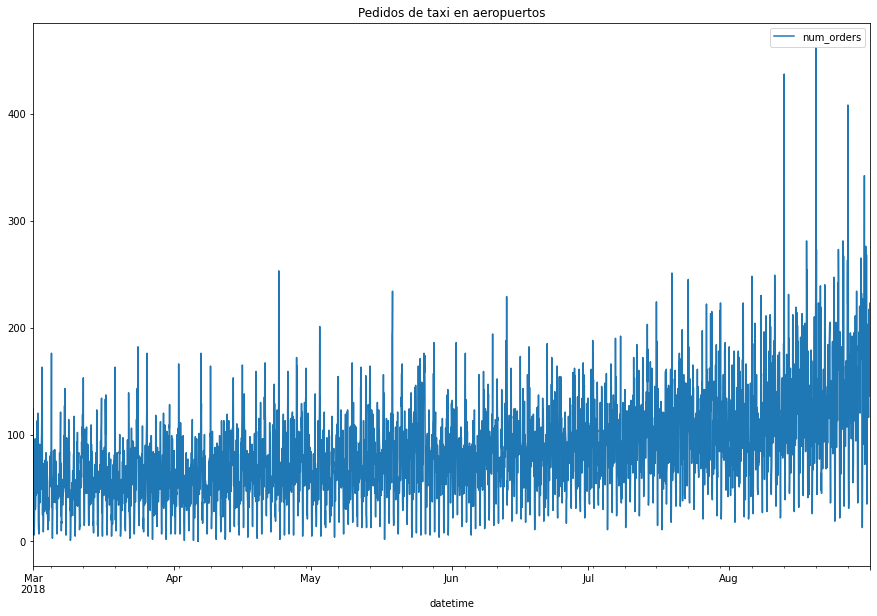

In [18]:

taxidf.plot(figsize=(15, 10), title='Pedidos de taxi en aeropuertos')
plt.show()

<div class="alert alert-block alert-success">

<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Excelente visualización temporal de los pedidos, sigamos!

**CONCLUSIÓN DEL ANALISIS**

De acuerdo a la información obtenida, no existen datos ausentes por lo que se procederá a trabajar con el dataframe completo. Se cambió a tipo de dato de tiempo desde la lectura del archivo para poder trabajar los datos como series temporales.

Tras remuestrear la información por hora, se obtiene la grafica anterior donde podemos ver que los datos van de marzo a agosto con una tendencia a subir conforme pasa el tiempo. 

## Formación

**Definición de función para la creación de nuevas características**

In [19]:
def new_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

<div class="alert alert-block alert-success">

<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Perfecto procedimiento del armado de los datos Tania, has extraido y calculado perfectamente como se debía, impresionatne!

**División de Dataframe en conjunto de entrenamiento y prueba a una relación 9:1**

In [20]:
new_features(taxidf, 3, 8)

taxidf = taxidf.dropna()
train, test = train_test_split(taxidf, shuffle=False, test_size=0.1)

train_features = train.drop(columns=['num_orders'])
train_target = train['num_orders']

test_features = test.drop(columns=['num_orders'])
test_target = test['num_orders']

In [21]:
display(taxidf.head(5))

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,52.750
2018-03-01 09:00:00,69,2018,3,1,3,9,34.0,15.0,12.0,41.500
2018-03-01 10:00:00,64,2018,3,1,3,10,69.0,34.0,15.0,39.500
2018-03-01 11:00:00,96,2018,3,1,3,11,64.0,69.0,34.0,38.625
2018-03-01 12:00:00,30,2018,3,1,3,12,96.0,64.0,69.0,42.375


<div class="alert alert-block alert-success">

<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Una división de los datos correcta, tal como debíamos hemos mantenido la consistencia temmporal cpn suffle = False, aquí para mejorarlo podriamos incrementar el porcentaje de división para test.

## Prueba

**Prueba de cordura con modelo de regresión lineal**

In [22]:
model = LinearRegression()
model.fit(train_features, train_target)

train_pred = model.predict(train_features)
test_pred = model.predict(test_features)

recm_train = mean_squared_error(train_target, train_pred)**0.5
recm_test = mean_squared_error(test_target, test_pred)**0.5

print('El valor RECM para el conjunto de entrenamiento es de:', recm_train)
print('El valor RECM para el conjunto de prueba es de:', recm_test)

El valor RECM para el conjunto de entrenamiento es de: 30.550408564507254
El valor RECM para el conjunto de prueba es de: 52.92359254189615


<div class="alert alert-block alert-success">

<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Excelente implementación de un modelo base como el de regresión lineal, bien implementado! A la vez un buen calculo de las métricas que correspondían.

**MODELO DE REGRESIÓN CON LGBMRegressor**

PRIMERA CONFIGURACIÓN

In [23]:
model_lgbtree = lgb.LGBMRegressor(
    boosting_type='gbdt', num_leaves=40, max_depth=20, learning_rate=0.1, random_state=12345)
model_lgbtree.fit(train_features, train_target)

predictions_train = model_lgbtree.predict(train_features)
predictions_test = model_lgbtree.predict(test_features)


recm_train = mean_squared_error(train_target, predictions_train)**0.5
recm_test = mean_squared_error(test_target, predictions_test)**0.5


print("RECM del modelo en datos de entrenamiento:", recm_train)
print()
print("RECM del modelo de árbol de decisiones en LightGBM:", recm_test)

RECM del modelo en datos de entrenamiento: 14.197497542536238

RECM del modelo de árbol de decisiones en LightGBM: 42.70009533650648


SEGUNDA CONFIGURACIÓN

In [24]:
model_lgbtree = lgb.LGBMRegressor(
    boosting_type='gbdt', num_leaves=50, max_depth=25, learning_rate=0.1, random_state=12345)
model_lgbtree.fit(train_features, train_target)

predictions_train = model_lgbtree.predict(train_features)
predictions_test = model_lgbtree.predict(test_features)


recm_train = mean_squared_error(train_target, predictions_train)**0.5
recm_test = mean_squared_error(test_target, predictions_test)**0.5


print("RECM del modelo en datos de entrenamiento:", recm_train)
print()
print("RECM del modelo de árbol de decisiones en LightGBM:", recm_test)

RECM del modelo en datos de entrenamiento: 13.112446297579053

RECM del modelo de árbol de decisiones en LightGBM: 42.407164024431374


**MODELO DE REGRESIÓN CON CatBoostRegressor**

PRIMERA CONFIGURACIÓN

In [25]:
model_cat = CatBoostRegressor(
    iterations=200, learning_rate=0.1, depth=8, random_seed=12345)
model_cat.fit(train_features, train_target,
              early_stopping_rounds=10, verbose=10)

predictions_train_cat = model_cat.predict(train_features)
predictions_test_cat = model_cat.predict(test_features)

recm_train_cat = mean_squared_error(train_target, predictions_train_cat)**0.5
recm_test_cat = mean_squared_error(test_target, predictions_test_cat) ** 0.5

print("RECM del modelo en datos de entrenamiento:", recm_train_cat)
print()
print("RECM del modelo de bosque aleatorio en CatBoost:", recm_test_cat)

0:	learn: 36.8165426	total: 6.71ms	remaining: 1.33s
10:	learn: 26.8674320	total: 64.2ms	remaining: 1.1s
20:	learn: 23.8234311	total: 124ms	remaining: 1.06s
30:	learn: 22.5795270	total: 189ms	remaining: 1.03s
40:	learn: 21.6642039	total: 251ms	remaining: 972ms
50:	learn: 21.1131560	total: 306ms	remaining: 894ms
60:	learn: 20.6201859	total: 360ms	remaining: 821ms
70:	learn: 20.0768435	total: 418ms	remaining: 759ms
80:	learn: 19.6336997	total: 476ms	remaining: 699ms
90:	learn: 19.2676866	total: 537ms	remaining: 644ms
100:	learn: 18.6975491	total: 592ms	remaining: 581ms
110:	learn: 18.3814400	total: 642ms	remaining: 515ms
120:	learn: 17.9629704	total: 697ms	remaining: 455ms
130:	learn: 17.6384460	total: 757ms	remaining: 399ms
140:	learn: 17.2544460	total: 814ms	remaining: 341ms
150:	learn: 16.9030194	total: 871ms	remaining: 283ms
160:	learn: 16.7027443	total: 932ms	remaining: 226ms
170:	learn: 16.3601402	total: 988ms	remaining: 168ms
180:	learn: 15.9895206	total: 1.04s	remaining: 110ms
190

SEGUNDA CONFIGURACIÓN

In [26]:
model_cat = CatBoostRegressor(
    iterations=250, learning_rate=0.05, depth=5, random_seed=12345)
model_cat.fit(train_features, train_target,
              early_stopping_rounds=10, verbose=10)

predictions_train_cat = model_cat.predict(train_features)
predictions_test_cat = model_cat.predict(test_features)

recm_train_cat = mean_squared_error(train_target, predictions_train_cat)**0.5
recm_test_cat = mean_squared_error(test_target, predictions_test_cat) ** 0.5

print("RECM del modelo en datos de entrenamiento:", recm_train_cat)
print()
print("RECM del modelo de bosque aleatorio en CatBoost:", recm_test_cat)

0:	learn: 37.7613349	total: 1.78ms	remaining: 444ms
10:	learn: 31.5692785	total: 19ms	remaining: 413ms
20:	learn: 28.3431796	total: 35.1ms	remaining: 383ms
30:	learn: 26.5188237	total: 51ms	remaining: 360ms
40:	learn: 25.3686712	total: 67.3ms	remaining: 343ms
50:	learn: 24.6466595	total: 83.4ms	remaining: 325ms
60:	learn: 24.2575557	total: 99.5ms	remaining: 308ms
70:	learn: 23.7641025	total: 115ms	remaining: 291ms
80:	learn: 23.5136534	total: 131ms	remaining: 273ms
90:	learn: 23.1977427	total: 146ms	remaining: 255ms
100:	learn: 22.8587414	total: 161ms	remaining: 238ms
110:	learn: 22.6010454	total: 176ms	remaining: 221ms
120:	learn: 22.3886713	total: 192ms	remaining: 204ms
130:	learn: 22.1662579	total: 208ms	remaining: 189ms
140:	learn: 21.9476737	total: 223ms	remaining: 173ms
150:	learn: 21.8439627	total: 247ms	remaining: 162ms
160:	learn: 21.6635998	total: 262ms	remaining: 145ms
170:	learn: 21.5688871	total: 277ms	remaining: 128ms
180:	learn: 21.3913839	total: 292ms	remaining: 111ms
1

<div class="alert alert-block alert-success">

<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Buenos armados de modelos alternativos Tania, has ido probando diferentes valores de hiperparámetros tal como era necesario para el proyecto. Impecable!

## Análisis de los modelos y conclusiones

| Hiperparámetros| Modelo|Librería|RECM en entrenamiento|RECM en prueba|
|:---------------|:-----:|:------:|:-------------------:|:----------------:|
| Configuración general |Regresión lineal|scikit-learn|30.55|52.92 |
| 1er Configuración|Árbol de decisiones |lightGBM| 14.19 |42.70|
| 2da Configuración|Árbol de decisiones |lightGBM| 13.11 | 42.40 |
| 1er Configuración|Bosque aleatorio |CATboost| 15.48| 45.29  |
| 2da Configuración|Bosque aleatorio |CATboost| 20.41 |45.38 |

<div class="alert alert-block alert-success">

<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Tania, solo queda felicitarte por el gran trabajo que has hecho, tanto tus conclusiones parciales como esta final demuestran tu gran comprensión sobre lo implementado. Nuevamente excelente!

Después de entrenar los conjuntos de entrenamiento y prueba podemos concluir que el mejor modelo para nuestra regresión es la segunda configuración del árbol de decisiones de la librería lightGBM. A pesar de que todos los modelos a excepción de la regresión lineal, cumplieron con el RECM objetivo. El que mejor desempeño tuvo fue el modelo mencionado, con el valor mas bajo en prueba de 42.40. Esto quiere decir que el número promedio de taxis pedidos por hora tendrá una variación de 42.4. 